In [113]:
import numpy as np
from matplotlib import pyplot as plt

We're going to use the 1 layer model shown below. It reduces the MNIST 28 x 28 inout to 8 x 8.

![1 Layer](1layer.png)

In [114]:
A = np.load('A.npy')
B = np.load('B.npy')
test_image = np.load('test_image_label_27_8x8.npy')
print(A.shape, A.dtype)
print(B.shape, B.dtype)
print(test_image.shape, test_image.dtype)

(10, 64) int8
(10,) int32
(8, 8) float32


In [115]:
print(0.011801077052950859 * A.flatten()[0:5])
print(0.000046278735680971295 *B[0:5])

[ 0.03540323  0.         -0.02360215  0.01180108 -0.04720431]
[-0.02179728  0.45218953 -0.00856157 -0.01416129 -0.0213345 ]


For index 27, the expected label is 4. Here's the expected tensor output, obtained by running the TFLite Interpretor on the same test image:

**[ 0  0  0  0  0  0  0  0  0 14]**

The same result from running TFLite Interpretor on the float32 model:

**[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.672785]**

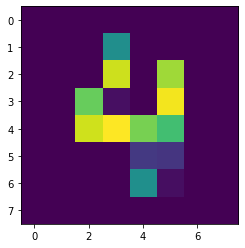

In [116]:
plt.imshow(test_image)
plt.show()

In [117]:
#print(test_image)
#print(test_image_uint8)

In [118]:
def ReLU(x):
    return x * (x > 0)

Here are the scales:

In [160]:
# scales 
S1 = 0.08342412859201431
S2 = 0.003921568859368563
S3 = S1*S2
Z2 = -128
Z3 = 0
S4 = 0.04645484685897827 
Z4 = -128
# confirm that S3 = S1*S2
print(0.08342412859201431*0.003921568859368563)

0.00032715346480640187


Now test the inference by converting weights to float using the quantization parameters in the file.

In [158]:
X = test_image.flatten()
X1 = np.matmul(S1*A, X) + S1*S2*B
print(X1)
X1 = ReLU(X1)
print(X1, X1.shape)
print("argmax: {}".format(np.argmax(X1)))
X1_uint8 = np.array(X1 / 0.04645484685897827, dtype=np.uint8)
print(X1_uint8)

[ -0.83851474 -19.45738979  -3.96955709  -0.95541077  -0.79326534
  -4.11794186  -5.06656371  -4.11967976  -2.02366908   0.6368044 ]
[-0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.         0.6368044] (10,)
argmax: 9
[ 0  0  0  0  0  0  0  0  0 13]


This matches with the TFlite interpretor output on the same data.

Now let's run this using integer math.

In [161]:
Xq = np.array(X/S2, dtype=np.uint8)
#print(Xq)
print(A.dtype, B.dtype)
X1 = np.zeros(B.shape, dtype=np.int32)
X1 += np.matmul(A.astype(np.int32), Xq)
X1 += B
print(np.matmul(A, Xq))
print(X1)
print(S1*S2*X1)
#print((S1*S2*X1/S4).astype(np.int8))
#print(np.clip((S1*S2*X1/S4).astype(np.int8), 0, 255))
print(ReLU(S1*S2*X1))
print(ReLU(S1*S2*X1)/S4)

int8 int32
[ -2085  -3445 -11872  -2607  -1951 -16246 -16991 -16420  -1122    637]
[ -2556 -59210 -12057  -2913  -2412 -12573 -15418 -12536  -6209   1961]
[ -0.83620426 -19.37075665  -3.94448933  -0.95299804  -0.78909416
  -4.11330051  -5.04405212  -4.10119583  -2.03129586   0.64154794]
[-0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.64154794]
[-0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         13.81014012]


In [124]:
Xq = X/S2
print(Xq)
X1 = np.matmul(A, Xq) + B
print(np.matmul(A, Xq))
print(X1)
print(S1*S2*X1)
print(ReLU(S1*S2*X1))
print(ReLU(S1*S2*X1)/S4)

[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         124.312485     0.           0.           0.
   0.           0.           0.           0.81249994 232.625
   0.         215.81248      0.           0.           0.
   0.         193.56248      9.9375       0.         247.68748
   0.           0.           0.           0.         233.68748
 251.62498    200.1875     175.18748      0.           0.
   0.           0.           0.           0.          41.4375
  39.           0.           0.           0.           0.
   0.           0.         125.37499      9.1875       0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]
[ -2092.0625 -69245.805  -11948.625   -2614.375   -1963.75   -16260.1875
 -17059.81   -16476.5     -1098.6862    622.5005]
[ -2563.0625     -59474.8046875  -12133.625       -2920.375
  -2424.75       -12587.1875     -15486.81054688 -

You get an error if you don't case A to int32:

In [162]:
X1 = np.matmul(A, X/S2)
print(X1)
Xq = np.array(X/S2, dtype=np.uint8)
X1 = np.matmul(A, Xq)
print(X1, X1.dtype)
print(np.dot(A[1].astype(np.int32), Xq))
print(np.dot(A[1], X/S2))

[ -2092.0625 -69245.805  -11948.625   -2614.375   -1963.75   -16260.1875
 -17059.81   -16476.5     -1098.6862    622.5005]
[ -2085  -3445 -11872  -2607  -1951 -16246 -16991 -16420  -1122    637] int16
-68981
-69245.805


# Pending Issues 

- How to do the scaling and saturating cast instead of using ReLU?